## mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "./drive/MyDrive/ML/FinalProject"
%ls

/content/drive/MyDrive/ML/FinalProject
000463202-20240611T233909Z-001/  data/     loss.pkl         __pycache__/       utils.py
000463202.csv                    data.pkl  ProjectSkeleton  transformer.ipynb


## load data

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from logging import exception
# get all the files under a dir
import os
import pandas as pd
from PIL import Image
import torchvision
from torchvision import transforms
from matplotlib import pyplot as plt
import torch


directory_path = "/content/drive/MyDrive/ML/FinalProject/"
directory_path = "/content/drive/MyDrive/1/"




In [5]:
import pickle
def pickle_dictionary(dictionary, file_path):
    try:
        with open(file_path, 'wb') as file:
            pickle.dump(dictionary, file)
        print(f"Dictionary has been pickled and saved to {file_path}")
    except Exception as e:
        print(f"An error occurred while pickling the dictionary: {e}")

# file_path = 'data.pkl'
# data_dict = {"folders_of_keypoints":folders_of_keypoints,
#              "folders_of_images":folders_of_images}
# pickle_dictionary(data_dict, file_path)

def unpickle_dictionary(file_path):
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except Exception as e:
        print(f"An error occurred while unpickling the dictionary: {e}")
        return None

loaded_dict = unpickle_dictionary("data.pkl")
folders_of_images = loaded_dict['folders_of_images']
folders_of_keypoints = loaded_dict['folders_of_keypoints']

In [6]:
# train test split
# folders frames
train_folders_images = []
test_folders_images = []
train_folders_keypoints = []
test_folders_keypoints = []

for i in range(len(folders_of_images)):
  if i % 10 == 2:
    test_folders_images.append(folders_of_images[i])
    test_folders_keypoints.append(folders_of_keypoints[i])
  else:
    train_folders_images.append(folders_of_images[i])
    train_folders_keypoints.append(folders_of_keypoints[i])

print(len(train_folders_images))
print(len(test_folders_images))
print(len(train_folders_keypoints))
print(len(test_folders_keypoints))

89
10
89
10


## transformer

In [7]:
import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

In [8]:
n_embd = 96
n_head = 3
dropout = 0.1
block_size = 100
n_layer = 6
keypoints = 36

In [44]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalGeneralAttention(nn.Module):

    def __init__(self):
        super().__init__()
        assert n_embd % n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn1 = nn.Linear(n_embd, 3 * n_embd, bias=False)
        self.c_attn2 = nn.Linear(n_embd, 3 * n_embd, bias=False)
        # output projection
        self.c_proj = nn.Linear(n_embd, n_embd, bias=False)
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        self.n_head = n_head
        self.n_embd = n_embd
        self.dropout = dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        # if not self.flash:
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(block_size, block_size))
                                    .view(1, 1, block_size, block_size))

        # k, v cache
        # keypoints_array = torch.rand((1000, 15))
        self.context_size = block_size

        self.k_cache = torch.zeros(0)
        self.v_cache = torch.zeros(0)
        self.l_cache = torch.zeros(0)
        self.w_cache = torch.zeros(0)
        self.wpe1 = nn.Embedding(block_size, n_embd)
        self.wpe2 = nn.Embedding(block_size, n_embd)

    def clear_cache(self):
        self.k_cache = torch.zeros(0)
        self.v_cache = torch.zeros(0)
        self.l_cache = torch.zeros(0)
        self.w_cache = torch.zeros(0)

    # general attention that pays attention to two sets of vectors
    def forward(self, x1, x2):
        C = x1.size()[1] # embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q1, k, v  = self.c_attn1(x1).split(self.n_embd, dim=1)
        q2, l, w  = self.c_attn2(x2).split(self.n_embd, dim=1)

        q = q1 + q2

        # if q, v cache is not full, add new k,v to it
        if self.k_cache.shape[0] < self.context_size:
          pass
        # q, v full then pop the first row before adding the row
        else:
          self.k_cache = self.k_cache[1:self.context_size, :]
          self.v_cache = self.v_cache[1:self.context_size, :]
          self.l_cache = self.l_cache[1:self.context_size, :]
          self.w_cache = self.w_cache[1:self.context_size, :]

        self.k_cache = torch.cat((self.k_cache, k), 0).detach()
        self.v_cache = torch.cat((self.v_cache, v), 0).detach()
        self.l_cache = torch.cat((self.l_cache, l), 0).detach()
        self.w_cache = torch.cat((self.w_cache, w), 0).detach()

        # construct add pos embedding to k, v
        pos = torch.arange(0, self.k_cache.shape[0], dtype=torch.long)
        pos_emb1 = self.wpe1(pos)
        pos_emb2 = self.wpe2(pos)

        # print(pos_emb.shape)

        e1 = (q @ (self.k_cache + pos_emb1).transpose(0, 1)) * (1.0 / math.sqrt(self.k_cache.size(-1)))
        e2 = (q @ (self.l_cache + pos_emb2).transpose(0, 1)) * (1.0 / math.sqrt(self.l_cache.size(-1)))
        att = torch.cat((e1, e2), 1)
        # print(f"the shape of e is {att.shape}")
        # att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        long_v = torch.cat((self.v_cache, self.w_cache), 0)
        long_pos_emb = torch.cat((pos_emb1, pos_emb2), 0)
        y = att @ (long_v + long_pos_emb)
        # shape (1 * n_embd)
        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class CausalSelfAttention(nn.Module):

    def __init__(self):
        super().__init__()
        assert n_embd % n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(n_embd, 3 * n_embd, bias=False)
        # output projection
        self.c_proj = nn.Linear(n_embd, n_embd, bias=False)
        # regularization
        self.attn_dropout = nn.Dropout(dropout)
        self.resid_dropout = nn.Dropout(dropout)
        self.n_head = n_head
        self.n_embd = n_embd
        self.dropout = dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        # if not self.flash:
        print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(block_size, block_size))
                                    .view(1, 1, block_size, block_size))

        # k, v cache
        # keypoints_array = torch.rand((1000, 15))
        self.context_size = block_size

        self.k_cache = torch.zeros(0)
        self.v_cache = torch.zeros(0)



    def clear_cache(self):
        self.k_cache = torch.zeros(0)
        self.v_cache = torch.zeros(0)

    def forward(self, x):



        C = x.size()[1] # embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=1)

        # if q, v cache is not full, add new k,v to it
        if self.k_cache.shape[0] < self.context_size:
          pass
        # q, v full then pop the first row before adding the row
        else:
          self.k_cache = self.k_cache[1:self.context_size, :]
          self.v_cache = self.v_cache[1:self.context_size, :]

        self.k_cache = torch.cat((self.k_cache, k), 0).detach()
        self.v_cache = torch.cat((self.v_cache, v), 0).detach()




        # print(pos_emb.shape)

        att = (q @ self.k_cache.transpose(0, 1)) * (1.0 / math.sqrt(self.k_cache.size(-1)))
        # att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ self.v_cache
        # shape (1 * n_embd)

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd, 4 * n_embd)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self):
        super().__init__()
        self.ln_1 = LayerNorm(n_embd, bias=False)
        self.attn = CausalSelfAttention()
        self.ln_2 = LayerNorm(n_embd, bias=False)
        self.mlp = MLP()

    def forward(self, x):
        x = self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class Transformer(nn.Module):

  def __init__(self) -> None:
      super().__init__()
      self.fc1 = nn.Linear(keypoints, n_embd)
      self.h = nn.ModuleList([Block() for _ in range(n_layer)])
      self.ln_f = LayerNorm(n_embd, False)
      self.lm_head = nn.Linear(n_embd, keypoints, bias=False)
      self.general_att = CausalGeneralAttention()

      self.apply(self._init_weights)

  def _init_weights(self, module):
      if isinstance(module, nn.Linear):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
          if module.bias is not None:
              torch.nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  # x1 is keypoints x2 is features
  def forward(self, x1, x2):
      x1 = self.fc1(x1)
      x = self.general_att(x1, x2)
      for block in self.h:
          x = block(x)
      x = self.ln_f(x)
      logits = self.lm_head(x)
      return logits



In [ ]:
# pos = torch.arange(0, 100, dtype=torch.long)
# print(pos)
# wpe = nn.Embedding(block_size, n_embd)
# print(wpe(pos).shape)
# ln_f = LayerNorm(n_embd, bias=False)
# lm_head = nn.Linear(n_embd, n_embd, bias=False)

In [ ]:
# input + pos embedding -> blocks -> ln -> head

## keypoints prediction model

In [ ]:
!pip install timm==0.5.4

In [11]:
import requests
import timm

In [45]:
class KeypointsPredictor(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.flatten = nn.Flatten()

    # internal models
    cnn_name = 'resnet18'
    self.cnn_model = timm.models.create_model(
        cnn_name,
        pretrained=True,
        num_classes=10)

    self.compress_features = nn.Sequential(
        nn.Linear(25088, 30*49), # for size 224 img feature is 512*7*7
        nn.ReLU(),
        nn.Linear(30*49, 12*49), # for size 224 img feature is 512*7*7
        nn.ReLU(),
        nn.Linear(12*49, 6*49),
        nn.ReLU(),
        nn.Linear(6*49, n_embd)
    )
    self.transformer = Transformer()


  # input is 3*84*84 img and its keypts (1*34 array, flattened from 2*17)
  def forward(self, keypoints, img):
    self.cnn_model.eval()
    features = self.cnn_model.forward_features(img)
    features = self.flatten(features)
    features = self.compress_features(features)
    x = self.transformer(keypoints, features)

    return x

In [84]:
class CnnBenchmark(nn.Module):
  def __init__(self) -> None:
    super().__init__()
    self.flatten = nn.Flatten()

    # internal models
    cnn_name = 'resnet18'
    self.cnn_model = timm.models.create_model(
        cnn_name,
        pretrained=True,
        num_classes=10)

    self.compress_features = nn.Sequential(
        nn.Linear(25088, 30*49), # for size 224 img feature is 512*7*7
        nn.ReLU(),
        nn.Linear(30*49, 12*49), # for size 224 img feature is 512*7*7
        nn.ReLU(),
        nn.Linear(12*49, 6*49),
        nn.ReLU(),
        nn.Linear(6*49, 96),
        nn.ReLU(),
        nn.Linear(96, 36)
    )
    self.head = nn.Linear(36, 36)



  # input is 3*84*84 img and its keypts (1*34 array, flattened from 2*17)
  def forward(self, keypoints, img):
    features = self.cnn_model.forward_features(img)
    features = self.flatten(features)
    features = self.compress_features(features)
    x = keypoints + features
    x = self.head(keypoints)
    return x

## train loop

In [13]:
def loss_fn(logits, targets):
  return ((logits - targets) ** 2).sum() / logits.shape[0]

In [60]:
model = KeypointsPredictor()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [85]:
ref_model = CnnBenchmark()
ref_optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [61]:
MEAN = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
STD = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)
transform_img = transforms.Compose([
        transforms.Normalize(MEAN, STD)
    ])

In [92]:

num_epoches = 1
iters = 0
def train_one_epoch(model, optimizer, loss_fn, clear_cache=False):
  loss_array = []
  for folder_idx in range(len(train_folders_images)):
    # one backprop per folder
    # clear k,v cache
    if clear_cache:
      model.transformer.general_att.clear_cache()
      for blc in model.transformer.h:
        blc.attn.clear_cache()
    loss = 0
    for img_idx in range(train_folders_images[folder_idx].shape[0]-1):
      # get correct datatype
      img = train_folders_images[folder_idx][img_idx].unsqueeze(0)
      img = img.to(torch.float)
      img = transform_img(img)
      keypoints = train_folders_keypoints[folder_idx][img_idx].view(1, -1)
      keypoints = keypoints.to(torch.float)

      pred = model(keypoints,
                  img)
      loss += loss_fn(pred.squeeze(),
                    train_folders_keypoints[folder_idx][img_idx+1])

      if img_idx == 25:
        print(pred.squeeze()[0:5])
        print(train_folders_keypoints[folder_idx][img_idx+1][0:5])
        print()

    loss /= train_folders_images[folder_idx].shape[0]
    loss_array.append(loss)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss_array


def test(model, loss_fn, clear_cache=False):
  loss_array = []
  model.eval()
  for folder_idx in range(len(test_folders_images)):
    # one backprop per folder
    # clear k,v cache
    if clear_cache:
      model.transformer.general_att.clear_cache()
      for blc in model.transformer.h:
        blc.attn.clear_cache()
    loss = 0
    for img_idx in range(test_folders_images[folder_idx].shape[0]-1):
      # get correct datatype
      img = test_folders_images[folder_idx][img_idx].unsqueeze(0)
      img = img.to(torch.float)
      img = transform_img(img)
      keypoints = test_folders_keypoints[folder_idx][img_idx].view(1, -1)
      keypoints = keypoints.to(torch.float)

      pred = model(keypoints,
                  img)
      loss += loss_fn(pred.squeeze(),
                    test_folders_keypoints[folder_idx][img_idx+1])

      if img_idx == 25:
        print(pred.squeeze()[0:5])
        print(test_folders_keypoints[folder_idx][img_idx+1][0:5])
        print()

    loss /= test_folders_images[folder_idx].shape[0]
    loss_array.append(loss.detach())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()







    print(f"loss at iteration {folder_idx} is {loss}")

  return loss_array



# keypoints_gt = None
# keypoints_pred = None
# # clear k,v cache
# model.transformer.general_att.clear_cache()
# for blc in model.transformer.h:
#   blc.attn.clear_cache()
# for i in range(1): #keypoints_tensor.shape[0]-1
#   # if the context is not yet full
#   # pred = model(keypoints_array[i].view(1, -1), imgs_array[i].unsqueeze(0))
#   pred = model(keypoints_tensor[i].view(1, -1), imgs_tensor[i].unsqueeze(0))
#   loss = loss_fn(pred.squeeze(), keypoints_tensor[i+1])
#   print(pred.squeeze()[0:3])
#   print(keypoints_tensor[i+1][0:3])
#   print()
#   # print(pred.squeeze().shape)
#   # print(keypoints_tensor[i+1].shape)
#   keypoints_gt = keypoints_tensor[i+1].detach()
#   keypoints_pred = pred.squeeze().detach()

#   loss.backward()
#   optimizer.step()
#   optimizer.zero_grad()



#   if i % 2 == 0:
#     print(f"loss is {loss}")
  # print(pred.shape)

In [63]:
tmodel_train_loss = []


In [79]:
cmodel_train_loss = []

In [ ]:

for i in range(num_epoches):
  loss_array = train_one_epoch(model, optimizer, loss_fn, True)
  tmodel_train_loss = tmodel_train_loss + loss_array


In [ ]:
for i in range(num_epoches):
  loss_array = train_one_epoch(ref_model, ref_optimizer, loss_fn, False)
  cmodel_train_loss = cmodel_train_loss + loss_array

In [93]:
t_test_loss = test(model, loss_fn, True)

tensor([82.7979, 51.8765, 86.2969, 67.2652, 78.6502], grad_fn=<SliceBackward0>)
tensor([209.6901,  -4.5609, 218.9598,   4.3018, 218.0429], dtype=torch.float64)

loss at iteration 0 is 3229.4531025310544
loss at iteration 1 is 4694.441165987139
tensor([134.2996,  68.5997, 146.0317,  98.2772, 134.0587],
       grad_fn=<SliceBackward0>)
tensor([51.0211, 48.6905, 41.5332, 75.3302, 31.5486], dtype=torch.float64)

loss at iteration 2 is 5055.029566022337
tensor([ 97.2564,  57.4411, 102.7652,  80.6434,  95.4300],
       grad_fn=<SliceBackward0>)
tensor([57.3921, 39.0118, 44.6821, 52.3648, 51.4342], dtype=torch.float64)

loss at iteration 3 is 2298.814212431018
tensor([79.5971, 50.3116, 80.7812, 70.3117, 76.6607], grad_fn=<SliceBackward0>)
tensor([133.9936,  18.9476, 134.0356,  31.3541, 113.9887], dtype=torch.float64)

loss at iteration 4 is 1883.8795134036623
tensor([90.6216, 45.5695, 92.7161, 63.6919, 86.4591], grad_fn=<SliceBackward0>)
tensor([89.8387, 71.9211, 94.0787, 87.0428, 89.1558], d

In [95]:
c_test_loss = test(ref_model, loss_fn, False)

tensor([ 45.3329,  88.0418, -41.3163,  -7.5892,  79.3756],
       grad_fn=<SliceBackward0>)
tensor([209.6901,  -4.5609, 218.9598,   4.3018, 218.0429], dtype=torch.float64)

loss at iteration 0 is 22340.896795131
loss at iteration 1 is 28360.190985593606
tensor([ 21.1092,  68.9628, -34.6744, -10.1181,  72.9865],
       grad_fn=<SliceBackward0>)
tensor([51.0211, 48.6905, 41.5332, 75.3302, 31.5486], dtype=torch.float64)

loss at iteration 2 is 13557.018087336171
tensor([ 17.0393,  49.3711, -32.9352, -16.9303,  63.1415],
       grad_fn=<SliceBackward0>)
tensor([57.3921, 39.0118, 44.6821, 52.3648, 51.4342], dtype=torch.float64)

loss at iteration 3 is 9906.369639649678
tensor([ 55.0036,  79.4214, -84.7383,  -8.1608,  70.1413],
       grad_fn=<SliceBackward0>)
tensor([133.9936,  18.9476, 134.0356,  31.3541, 113.9887], dtype=torch.float64)

loss at iteration 4 is 14085.409780591312
tensor([ 63.0279,  81.9647, -37.4105, -13.1695,  47.0387],
       grad_fn=<SliceBackward0>)
tensor([89.8387, 71.

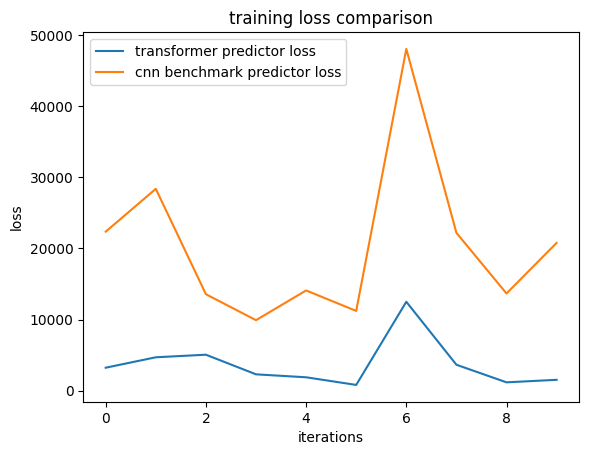

In [96]:
plt.title("training loss comparison")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.plot(t_test_loss, label="transformer predictor loss")
plt.plot(c_test_loss, label="cnn benchmark predictor loss")
plt.legend()
plt.show()

In [ ]:
plt.title("testing loss comparison")
plt.xlabel("iterations")
plt.ylabel("loss")
plt.plot(tmodel_train_loss, label="transformer predictor loss")
plt.plot(cmodel_train_loss, label="cnn benchmark predictor loss")
plt.legend()
plt.show()

## visualize keypoints

In [97]:
import numpy as np

def visualize_keypoints(img, keypoints, predicted_keypoints):


    fig, ax = plt.subplots()
    ax.imshow(img)

    keypoints = np.array(keypoints)
    predicted_keypoints = np.array(predicted_keypoints)
    kpx = [keypoints[2*i] for i in range(18)]
    kpy = [keypoints[2*i+1] for i in range(18)]
    ppx = [predicted_keypoints[2*i] for i in range(18)]
    ppy = [predicted_keypoints[2*i+1] for i in range(18)]
    ax.scatter(kpx, kpy, c='blue', s=10, label='Original Keypoints')
    ax.scatter(ppx, ppy, c='red', s=10, label='Predicted Keypoints')

    plt.legend()
    plt.show()

# Example usage
image_path = 'path_to_image.png'  # Path to the image



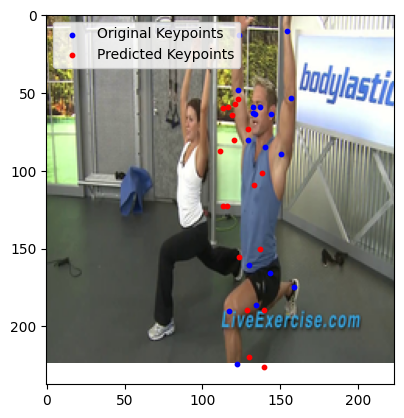

In [107]:
# folder 2 image 23
model.eval()
img = test_folders_images[5][17].unsqueeze(0)
img = img.to(torch.float)
img = transform_img(img)
keypoints = test_folders_keypoints[5][17].view(1, -1)
keypoints = keypoints.to(torch.float)

gt = test_folders_keypoints[5][18]

pred = model(keypoints,
                  img)
pred = pred.squeeze()

pred = pred.detach()
gt = gt.detach()

to_pil_image = transforms.ToPILImage()
pil_image = to_pil_image(test_folders_images[5][18])
visualize_keypoints(pil_image, gt, pred)
i += 1